# Euclid Q1: 1D spectra

## Learning Goals

By the end of this tutorial, you will:
- Understand the basic characteristics of Euclid Q1 SIR 1D spectra.
- What columns are available in the MER catalog.
- How to query with ADQL in the MER catalog.
- How to make a simple color-magnitude diagram with the data.

## Introduction

Euclid launched in July 2023 as a European Space Agency (ESA) mission with involvement by NASA.
The primary science goals of Euclid are to better understand the composition and evolution of the dark Universe.
The Euclid mission is providing space-based imaging and spectroscopy as well as supporting ground-based imaging to achieve these primary goals.
These data will be archived by multiple global repositories, including IRSA, where they will support transformational work in many areas of astrophysics.

Euclid Quick Release 1 (Q1) consists of consists of ~30 TB of imaging, spectroscopy, and catalogs covering four non-contiguous fields:
Euclid Deep Field North (22.9 sq deg), Euclid Deep Field Fornax (12.1 sq deg), Euclid Deep Field South (28.1 sq deg), and LDN1641.

Among the data products included in the Q1 release are the 1D spectra created by the SIR Processing Function.
This notebook provides an introduction to these SIR 1D spectra.
If you have questions about it, please contact the [IRSA helpdesk](https://irsa.ipac.caltech.edu/docs/help_desk.html).

## Imports

```{important}
We rely on ``astroquery`` features that have been recently added, so please make sure you have version v0.4.10 or newer installed.
```

In [1]:
# Uncomment the next line to install dependencies if needed
# !pip install matplotlib astropy 'astroquery>=0.4.10'

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import QTable
from astropy import units as u
from astropy.visualization import quantity_support

from astroquery.ipac.irsa import Irsa

## 1. Search for the spectrum of a specific galaxy

First, explore what Euclid catalogs are available. Note that we need to use the object ID for our targets to be able to download their spectrum.

Search for all tables in IRSA labeled as "euclid".

In [3]:
Irsa.list_catalogs(filter='euclid')

{'euclid_q1_mer_catalogue': 'Euclid Q1 MER Catalog'}

In [4]:
table_1dspectra = 'euclid.objectid_spectrafile_association_q1'

## 2. Search for the spectrum of a specific galaxy in the 1D spectra table

In [5]:
obj_id = 2689918641685825137

We will use TAP and an ASQL query to find the spectral data for our galaxy. (ADQL is the [IVOA Astronomical Data Query Language](https://www.ivoa.net/documents/latest/ADQL.html) and is based on SQL.)

In [6]:
adql_object = f"SELECT * FROM {table_1dspectra} WHERE objectid = {obj_id}"

# Pull the data on this particular galaxy
result = Irsa.query_tap(adql_object).to_table()

Pull out the file name from the ``result`` table:

In [7]:
spectrum_path = f"https://irsa.ipac.caltech.edu/{result['path'][0]}"
spectrum_path

'https://irsa.ipac.caltech.edu/api/spectrumdm/convert/euclid/q1/SIR/102160608/EUC_SIR_W-COMBSPEC_102160608_2024-11-05T16:42:00.741819Z.fits?dataset_id=euclid_combspec&hdu=321'

## 3. Read in the spectrum for only our specific object

`spectrum_path` is a url that will return a VOTable containing the spectrum of our object.

In [8]:
spectrum = QTable.read(spectrum_path)

In [9]:
spectrum

WAVELENGTH,SIGNAL,MASK,QUALITY,VAR,NDITH,UNCERTAINTY
Angstrom,1e-16 erg / (Angstrom s cm2),,,1e-32 erg2 / (Angstrom2 s2 cm4),,1e-16 erg / (Angstrom s cm2)
float32,float32,int32,float32,float32,int32,float32
11900.0,0.0,1,0.0,0.0,0,0.0
11913.400390625,0.0,1,0.0,0.0,0,0.0
11926.7998046875,0.0,1,0.0,0.0,0,0.0
11940.2001953125,-0.42825955152511597,64,0.92492783,0.05231768637895584,2,0.22873060405254364
11953.599609375,-0.019433781504631042,66,0.85617656,0.010498150251805782,2,0.10246048122644424
11967.0,0.02915639616549015,64,0.8876306,0.003435363294556737,4,0.058611974120140076
11980.400390625,0.08275385200977325,80,0.0,0.0017151220235973597,4,0.04141402989625931
11993.7998046875,0.018765779212117195,64,0.8546597,0.0009618347976356745,4,0.03101346082985401


## 4. Plot the image of the extracted spectrum

```{tip}
As we use astropy.visualization's ``quantity_support``, matplotlib automatically picks up the axis units from the quantities we plot.
```

In [10]:
quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x7fec47719e90>

```{note}
The 1D combined spectra table contains 6 columns, below are a few highlights:

- WAVELENGTH is in Angstroms by default.
- SIGNAL is the flux. The values are scaled and the scaling factor is included in the column's units. This value corresponds to the `'FSCALE'` entry in the HDU header of the original FITS file.
- MASK values can be used to determine which flux bins to discard. MASK = odd and MASK >=64 means the flux bins not be used.
```

We investigate the MASK column to see which flux bins are recommended to keep vs "Do Not Use"

Text(0.5, 1.0, 'Values of MASK by flux bin')

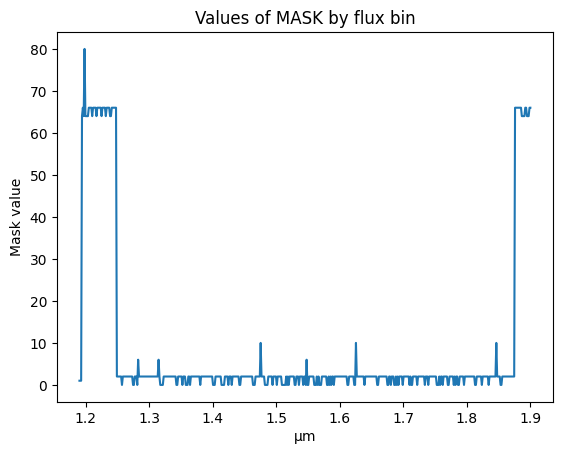

In [11]:
plt.plot(spectrum['WAVELENGTH'].to(u.micron), spectrum['MASK'])
plt.ylabel('Mask value')
plt.title('Values of MASK by flux bin')

We use the MASK column to create a boolean mask for values to ignore. We use the inverse of this mask to mark the flux bins to use.

Text(0.5, 1.0, 'Object ID 2689918641685825137')

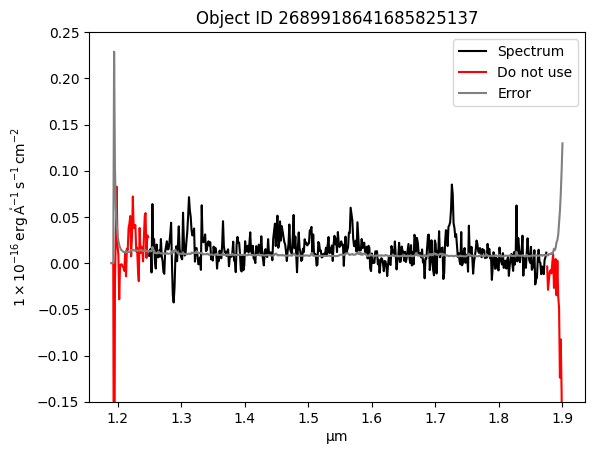

In [12]:
bad_mask = (spectrum['MASK'].value % 2 == 1) | (spectrum['MASK'].value >= 64)

plt.plot(spectrum['WAVELENGTH'].to(u.micron), np.ma.masked_where(bad_mask, spectrum['SIGNAL']), color='black', label='Spectrum')
plt.plot(spectrum['WAVELENGTH'], np.ma.masked_where(~bad_mask, spectrum['SIGNAL']), color='red', label='Do not use')
plt.plot(spectrum['WAVELENGTH'], np.sqrt(spectrum['VAR']), color='grey', label='Error')

plt.legend(loc='upper right')
plt.ylim(-0.15, 0.25)
plt.title(f'Object ID {obj_id}')

## About this Notebook

**Author**: Tiffany Meshkat, Anahita Alavi, Anastasia Laity, Andreas Faisst, Brigitta Sipőcz, Dan Masters, Harry Teplitz, Jaladh Singhal, Shoubaneh Hemmati, Vandana Desai, Troy Raen

**Updated**: 2025-09-23

**Contact:** [the IRSA Helpdesk](https://irsa.ipac.caltech.edu/docs/help_desk.html) with questions or reporting problems.